In [1]:
%load_ext jupyter_black
import torch
import torch.optim as optim
import torch.nn as nn
from optimizers.lsgd import LSGD
from optimizers.lrmsprop import LRMSprop
from optimizers.ladam import LAdam
from optimizers.ladadelta import LAdadelta
import matplotlib.pyplot as plt
import numpy as np
import scienceplots
import tqdm
import math
from training.train import train
from diffusion.deephedging import DeepHedging
from scheduler import PiecewiseConstantScheduler

plt.style.use(["grid", "science", "no-latex"])

seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [69]:
def plot_langevin_loss(
    test_loss,
    test_ci,
    test_loss_langevin,
    test_ci_langevin,
    test_loss_llangevin=None,
    test_ci_llangevin=None,
    ll=10,
    name="SGD",
    xlim: tuple[float, float] = None,
    ylim: tuple[float, float] = None,
):
    fig = plt.figure(figsize=(7, 5))
    plt.plot(
        np.arange(len(test_loss)), test_loss, marker="o", mec="k", ms=5, label=name
    )
    plt.fill_between(
        np.arange(len(test_loss)),
        np.array(test_loss) - np.array(test_ci),
        np.array(test_loss) + np.array(test_ci),
        alpha=0.2,
    )
    plt.plot(
        np.arange(len(test_loss_langevin)),
        test_loss_langevin,
        marker="o",
        mec="k",
        ms=5,
        label=f"L{name}",
    )
    plt.fill_between(
        np.arange(len(test_loss_langevin)),
        np.array(test_loss_langevin) - np.array(test_ci_langevin),
        np.array(test_loss_langevin) + np.array(test_ci_langevin),
        alpha=0.2,
    )
    if test_loss_llangevin:
        if isinstance(test_loss_llangevin, list):
            if not isinstance(test_ci_llangevin, list) or not isinstance(ll, list):
                raise ValueError("Expected a list of test_ci_llangevin and ll")
            for test_loss_ll, test_ci_ll, ll_rate in zip(
                test_loss_llangevin, test_ci_llangevin, ll
            ):
                plt.plot(
                    np.arange(len(test_loss_ll)),
                    test_loss_ll,
                    marker="o",
                    mec="k",
                    ms=5,
                    label=f"LL{name}-{ll_rate}%",
                )
                plt.fill_between(
                    np.arange(len(test_loss_ll)),
                    np.array(test_loss_ll) - np.array(test_ci_ll),
                    np.array(test_loss_ll) + np.array(test_ci_ll),
                    alpha=0.2,
                )
        else:
            plt.plot(
                np.arange(len(test_loss_llangevin)),
                test_loss_llangevin,
                marker="o",
                mec="k",
                ms=5,
                label=f"LL{name}-{ll}%",
            )
            plt.fill_between(
                np.arange(len(test_loss_llangevin)),
                np.array(test_loss_llangevin) - np.array(test_ci_llangevin),
                np.array(test_loss_llangevin) + np.array(test_ci_llangevin),
                alpha=0.2,
            )

    plt.xlabel("Epochs")
    plt.ylabel(r"$J(u_\theta)$")
    if xlim:
        plt.xlim(xlim)
    if ylim:
        plt.ylim(ylim)
    plt.legend()
    plt.show()
    plt.close()

### Single control:

In [3]:
train_batch = 512
test_batch = 512
train_size = 5
test_size = 25
epochs = 100

In [4]:
alpha = 0.9
ell = lambda x: nn.functional.relu(x) / (1.0 - alpha)
dim = 5
s0 = 1.0
v0 = 0.1


model_config = dict(
    T=1.0,
    N_euler=50,
    dim=dim,
    ell=ell,
    a=torch.ones(dim),
    b=0.04 * torch.ones(dim),
    sigma=2.0 * torch.ones(dim),
    rho=-0.7 * torch.ones(dim),
    K=s0 * torch.ones(dim),
    T_COST=5e-4,
    S_0=s0 * torch.ones(dim),
    V_0=v0 * torch.ones(dim),
)

control_config = dict(
    input_dim=1 + 4 * dim,
    output_dim=2 * dim,
    hidden_dim=32,
    depth=2,
    activation=nn.ReLU(),
    out_transform=nn.ReLU(),
)

In [5]:
ocp = DeepHedging(**model_config)
ocp.set_control(control_config, multiple_controls=False)
adam_w = optim.Adam(ocp.w.parameters(), lr=2e-3)
adam_control = optim.Adam(ocp.control.parameters(), lr=2e-3)
adam = [adam_w, adam_control]

scheduler_w = PiecewiseConstantScheduler(
    adam_w, target_lr=2e-4, target_sigma=0, total_iters=80
)
scheduler_control = PiecewiseConstantScheduler(
    adam_control, target_lr=2e-4, target_sigma=0, total_iters=80
)
scheduler = [scheduler_w, scheduler_control]

In [6]:
train_loss_adam, test_loss_adam, test_ci_adam = train(
    ocp,
    adam,
    scheduler,
    "Adam",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Deep hedging: Epoch 99, Adam, lr=0.00020, sigma=[0], train=0.497, test=0.479: 100%|██████████| 100/100 [00:45<00:00,  2.19it/s]


In [19]:
ocp = DeepHedging(**model_config)
ocp.set_control(control_config, multiple_controls=False)
ladam_w = LAdam(ocp.w.parameters(), lr=2e-3, sigma=2e-4)
ladam_control = LAdam(ocp.control.parameters(), lr=2e-3, sigma=2e-4)
ladam = [ladam_w, ladam_control]

scheduler_w = PiecewiseConstantScheduler(
    ladam_w, target_lr=2e-4, target_sigma=0, total_iters=80
)
scheduler_control = PiecewiseConstantScheduler(
    ladam_control, target_lr=2e-4, target_sigma=0, total_iters=80
)
scheduler = [scheduler_w, scheduler_control]

In [20]:
train_loss_ladam, test_loss_ladam, test_ci_ladam = train(
    ocp,
    ladam,
    scheduler,
    "LAdam",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Deep hedging: Epoch 99, LAdam, lr=0.00020, sigma=[0], train=0.278, test=0.287: 100%|██████████| 100/100 [00:48<00:00,  2.05it/s]    


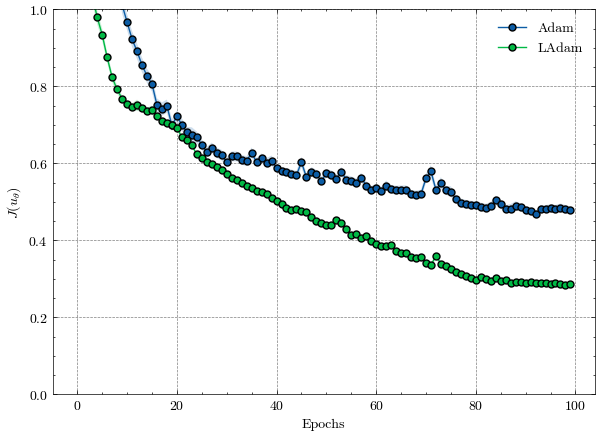

In [30]:
plot_langevin_loss(
    test_loss_adam,
    test_ci_adam,
    test_loss_ladam,
    test_ci_ladam,
    name="Adam",
    ylim=(0, 1),
)

In [22]:
ocp = DeepHedging(**model_config)
ocp.set_control(control_config, multiple_controls=False)
adadelta_w = optim.Adadelta(ocp.w.parameters(), lr=5e-1, rho=0.95)
adadelta_control = optim.Adadelta(ocp.control.parameters(), lr=5e-1, rho=0.95)
adadelta = [adadelta_w, adadelta_control]

scheduler_w = PiecewiseConstantScheduler(
    adadelta_w, target_lr=5e-2, target_sigma=0, total_iters=80
)
scheduler_control = PiecewiseConstantScheduler(
    adadelta_control, target_lr=5e-2, target_sigma=0, total_iters=80
)
scheduler = [scheduler_w, scheduler_control]

In [23]:
train_loss_adadelta, test_loss_adadelta, test_ci_adadelta = train(
    ocp,
    adadelta,
    scheduler,
    "Adadelta",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Deep hedging: Epoch 99, Adadelta, lr=0.05000, sigma=[0], train=0.346, test=0.348: 100%|██████████| 100/100 [00:46<00:00,  2.13it/s]


In [24]:
ocp = DeepHedging(**model_config)
ocp.set_control(control_config, multiple_controls=False)
ladadelta_w = LAdadelta(ocp.w.parameters(), lr=5e-1, sigma=5e-3)
ladadelta_control = LAdadelta(ocp.control.parameters(), lr=5e-1, sigma=5e-3)
ladadelta = [ladadelta_w, ladadelta_control]

scheduler_w = PiecewiseConstantScheduler(
    ladadelta_w, target_lr=5e-2, target_sigma=0, total_iters=80
)
scheduler_control = PiecewiseConstantScheduler(
    ladadelta_control, target_lr=5e-2, target_sigma=0, total_iters=80
)
scheduler = [scheduler_w, scheduler_control]

In [25]:
train_loss_ladadelta, test_loss_ladadelta, test_ci_ladadelta = train(
    ocp,
    ladadelta,
    scheduler,
    "LAdadelta",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Deep hedging: Epoch 99, LAdadelta, lr=0.05000, sigma=[0], train=0.282, test=0.285: 100%|██████████| 100/100 [00:46<00:00,  2.16it/s]   


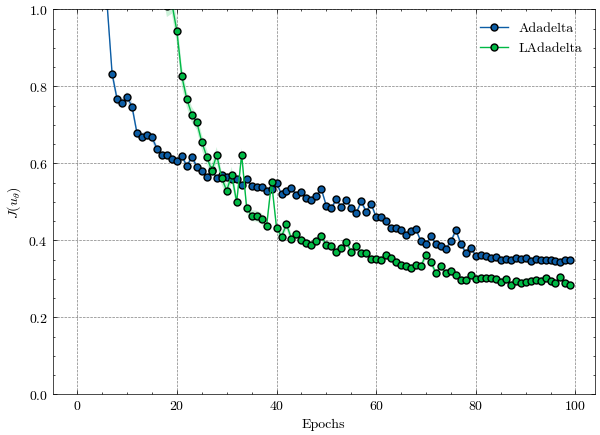

In [29]:
plot_langevin_loss(
    test_loss_adadelta,
    test_ci_adadelta,
    test_loss_ladadelta,
    test_ci_ladadelta,
    name="Adadelta",
    ylim=(0, 1),
)

### Multiple controls:

In [71]:
model_config = dict(
    T=1.0,
    N_euler=10,
    dim=dim,
    ell=ell,
    a=torch.ones(dim),
    b=0.04 * torch.ones(dim),
    sigma=2.0 * torch.ones(dim),
    rho=-0.7 * torch.ones(dim),
    K=s0 * torch.ones(dim),
    T_COST=5e-4,
    S_0=s0 * torch.ones(dim),
    V_0=v0 * torch.ones(dim),
)

control_config = dict(
    input_dim=4 * dim,
    output_dim=2 * dim,
    hidden_dim=32,
    depth=2,
    activation=nn.ReLU(),
    out_transform=nn.ReLU(),
)

epochs = 200

In [72]:
ocp = DeepHedging(**model_config)
ocp.set_control(control_config, multiple_controls=True)
adam_w = optim.Adam(ocp.w.parameters(), lr=2e-3)
adam_control = [optim.Adam(control.parameters(), lr=2e-3) for control in ocp.control]
adam = [adam_w, *adam_control]

scheduler_w = PiecewiseConstantScheduler(
    adam_w, target_lr=2e-4, target_sigma=0, total_iters=80
)
scheduler_control = [
    PiecewiseConstantScheduler(opt, target_lr=2e-4, target_sigma=0, total_iters=180)
    for opt in adam_control
]
scheduler = [scheduler_w, *scheduler_control]

In [73]:
train_loss_adam, test_loss_adam, test_ci_adam = train(
    ocp,
    adam,
    scheduler,
    "Adam",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Training Deep hedging with Adam:   0%|          | 0/200 [00:00<?, ?it/s]

Deep hedging: Epoch 199, Adam, lr=0.00020, sigma=[0], train=0.917, test=0.892: 100%|██████████| 200/200 [00:21<00:00,  9.31it/s]


In [74]:
ocp = DeepHedging(**model_config)
ocp.set_control(control_config, multiple_controls=True)
ladam_w = LAdam(ocp.w.parameters(), lr=2e-3, sigma=2e-4)
ladam_control = [
    LAdam(control.parameters(), lr=2e-3, sigma=2e-4) for control in ocp.control
]
ladam = [ladam_w, *ladam_control]

scheduler_w = PiecewiseConstantScheduler(
    ladam_w, target_lr=2e-4, target_sigma=0, total_iters=180
)
scheduler_control = [
    PiecewiseConstantScheduler(opt, target_lr=2e-4, target_sigma=0, total_iters=180)
    for opt in ladam_control
]
scheduler = [scheduler_w, *scheduler_control]

In [75]:
train_loss_ladam, test_loss_ladam, test_ci_ladam = train(
    ocp,
    ladam,
    scheduler,
    "LAdam",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Deep hedging: Epoch 199, LAdam, lr=0.00020, sigma=[0], train=0.432, test=0.326: 100%|██████████| 200/200 [00:23<00:00,  8.68it/s]     


In [76]:
ocp = DeepHedging(**model_config)
ocp.set_control(control_config, multiple_controls=True)
ladam_w = LAdam(ocp.w.parameters(), lr=2e-3, sigma=2e-4)
ll = 30
lladam_control = []
for i, control in enumerate(ocp.control):
    if 100 * i / len(ocp.control) <= ll:
        lladam_control.append(LAdam(control.parameters(), lr=2e-3, sigma=2e-4))
    else:
        lladam_control.append(optim.Adam(control.parameters(), lr=2e-3))

lladam = [ladam_w, *lladam_control]

scheduler_w = PiecewiseConstantScheduler(
    ladam_w, target_lr=2e-4, target_sigma=0, total_iters=180
)
scheduler_control = [
    PiecewiseConstantScheduler(opt, target_lr=2e-4, target_sigma=0, total_iters=180)
    for opt in lladam_control
]
scheduler = [scheduler_w, *scheduler_control]

In [77]:
train_loss_ll30_adam, test_loss_ll30_adam, test_ci_ll30_adam = train(
    ocp,
    lladam,
    scheduler,
    "LLAdam",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Deep hedging: Epoch 199, LLAdam, lr=0.00020, sigma=[0], train=0.294, test=0.358: 100%|██████████| 200/200 [00:21<00:00,  9.48it/s]


In [78]:
ocp = DeepHedging(**model_config)
ocp.set_control(control_config, multiple_controls=True)
ladam_w = LAdam(ocp.w.parameters(), lr=2e-3, sigma=2e-4)
ll = 90
lladam_control = []
for i, control in enumerate(ocp.control):
    if 100 * i / len(ocp.control) <= ll:
        lladam_control.append(LAdam(control.parameters(), lr=2e-3, sigma=2e-4))
    else:
        lladam_control.append(optim.Adam(control.parameters(), lr=2e-3))

lladam = [ladam_w, *lladam_control]

scheduler_w = PiecewiseConstantScheduler(
    ladam_w, target_lr=2e-4, target_sigma=0, total_iters=180
)
scheduler_control = [
    PiecewiseConstantScheduler(opt, target_lr=2e-4, target_sigma=0, total_iters=180)
    for opt in lladam_control
]
scheduler = [scheduler_w, *scheduler_control]

In [79]:
train_loss_ll90_adam, test_loss_ll90_adam, test_ci_ll90_adam = train(
    ocp,
    lladam,
    scheduler,
    "LLAdam",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Deep hedging: Epoch 199, LLAdam, lr=0.00020, sigma=[0], train=0.284, test=0.350: 100%|██████████| 200/200 [00:21<00:00,  9.44it/s]     


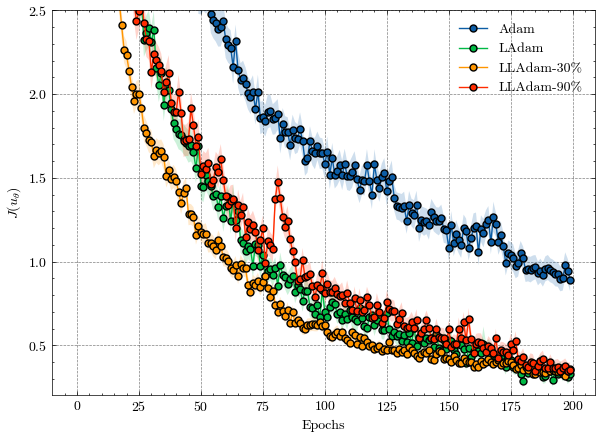

In [93]:
plot_langevin_loss(
    test_loss_adam,
    test_ci_adam,
    test_loss_ladam,
    test_ci_ladam,
    test_loss_llangevin=[test_loss_ll30_adam, test_loss_ll90_adam],
    test_ci_llangevin=[test_ci_ll30_adam, test_ci_ll90_adam],
    ll=[30, 90],
    name="Adam",
    ylim=(0.2, 2.5),
)

In [134]:
ocp = DeepHedging(**model_config)
ocp.set_control(control_config, multiple_controls=True)
adadelta_w = optim.Adadelta(ocp.w.parameters(), lr=5e-1, rho=0.95)
adadelta_control = [
    optim.Adadelta(control.parameters(), lr=5e-1, rho=0.95) for control in ocp.control
]
adadelta = [adadelta_w, *adadelta_control]

scheduler_w = PiecewiseConstantScheduler(
    adadelta_w, target_lr=5e-2, target_sigma=0, total_iters=180
)
scheduler_control = [
    PiecewiseConstantScheduler(opt, target_lr=5e-2, target_sigma=0, total_iters=180)
    for opt in adadelta_control
]
scheduler = [scheduler_w, *scheduler_control]

In [135]:
train_loss_adadelta, test_loss_adadelta, test_ci_adadelta = train(
    ocp,
    adadelta,
    scheduler,
    "Adadelta",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Deep hedging: Epoch 199, Adadelta, lr=0.05000, sigma=[0], train=0.619, test=0.611: 100%|██████████| 200/200 [00:20<00:00,  9.86it/s]


In [136]:
ocp = DeepHedging(**model_config)
ocp.set_control(control_config, multiple_controls=True)
adadelta_w = optim.Adadelta(ocp.w.parameters(), lr=5e-1, rho=0.95)
ladadelta_control = [
    LAdadelta(control.parameters(), lr=5e-1, sigma=5e-3) for control in ocp.control
]
ladadelta = [adadelta_w, *ladadelta_control]

scheduler_w = PiecewiseConstantScheduler(
    adadelta_w, target_lr=5e-2, target_sigma=0, total_iters=180
)
scheduler_control = [
    PiecewiseConstantScheduler(opt, target_lr=5e-2, target_sigma=0, total_iters=180)
    for opt in ladadelta_control
]
scheduler = [scheduler_w, *scheduler_control]

In [137]:
train_loss_ladadelta, test_loss_ladadelta, test_ci_ladadelta = train(
    ocp,
    ladadelta,
    scheduler,
    "LAdadelta",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Deep hedging: Epoch 199, LAdadelta, lr=0.05000, sigma=[0], train=0.314, test=0.294: 100%|██████████| 200/200 [00:20<00:00,  9.66it/s]    


In [138]:
ocp = DeepHedging(**model_config)
ocp.set_control(control_config, multiple_controls=True)
adadelta_w = optim.Adadelta(ocp.w.parameters(), lr=5e-1, rho=0.95)
ll = 30
lladadelta_control = []
for i, control in enumerate(ocp.control):
    if 100 * i / len(ocp.control) <= ll:
        lladadelta_control.append(LAdadelta(control.parameters(), lr=5e-1, sigma=5e-3))
    else:
        lladadelta_control.append(
            optim.Adadelta(control.parameters(), lr=5e-1, rho=0.95)
        )

lladadelta = [adadelta_w, *lladadelta_control]

scheduler_w = PiecewiseConstantScheduler(
    adadelta_w, target_lr=5e-2, target_sigma=0, total_iters=180
)
scheduler_control = [
    PiecewiseConstantScheduler(opt, target_lr=5e-2, target_sigma=0, total_iters=180)
    for opt in lladadelta_control
]
scheduler = [scheduler_w, *scheduler_control]

In [139]:
train_loss_ll30_adadelta, test_loss_ll30_adadelta, test_ci_ll30_adadelta = train(
    ocp,
    lladadelta,
    scheduler,
    "LLAdadelta",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Deep hedging: Epoch 199, LLAdadelta, lr=0.05000, sigma=[0], train=0.537, test=0.513: 100%|██████████| 200/200 [00:20<00:00,  9.97it/s]


In [140]:
ocp = DeepHedging(**model_config)
ocp.set_control(control_config, multiple_controls=True)
adadelta_w = optim.Adadelta(ocp.w.parameters(), lr=5e-1, rho=0.95)
ll = 90
lladadelta_control = []
for i, control in enumerate(ocp.control):
    if 100 * i / len(ocp.control) <= ll:
        lladadelta_control.append(LAdadelta(control.parameters(), lr=5e-1, sigma=5e-3))
    else:
        lladadelta_control.append(
            optim.Adadelta(control.parameters(), lr=5e-1, rho=0.95)
        )

lladadelta = [adadelta_w, *lladadelta_control]

scheduler_w = PiecewiseConstantScheduler(
    adadelta_w, target_lr=5e-2, target_sigma=0, total_iters=180
)
scheduler_control = [
    PiecewiseConstantScheduler(opt, target_lr=5e-2, target_sigma=0, total_iters=180)
    for opt in lladadelta_control
]
scheduler = [scheduler_w, *scheduler_control]

In [141]:
train_loss_ll90_adadelta, test_loss_ll90_adadelta, test_ci_ll90_adadelta = train(
    ocp,
    lladadelta,
    scheduler,
    "LLAdadelta",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Deep hedging: Epoch 199, LLAdadelta, lr=0.05000, sigma=[0], train=0.342, test=0.349: 100%|██████████| 200/200 [00:20<00:00,  9.66it/s]    


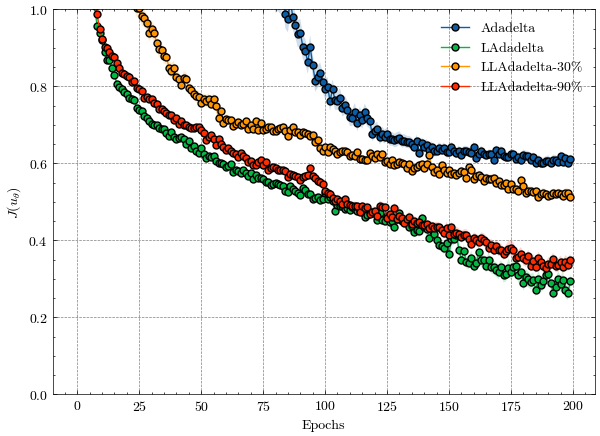

In [143]:
plot_langevin_loss(
    test_loss_adadelta,
    test_ci_adadelta,
    test_loss_ladadelta,
    test_ci_ladadelta,
    test_loss_llangevin=[test_loss_ll30_adadelta, test_loss_ll90_adadelta],
    test_ci_llangevin=[test_ci_ll30_adadelta, test_ci_ll90_adadelta],
    ll=[30, 90],
    name="Adadelta",
    ylim=(0, 1),
)

In [153]:
ocp = DeepHedging(**model_config)
ocp.set_control(control_config, multiple_controls=True)
rmsprop_w = optim.RMSprop(ocp.w.parameters(), lr=2e-3)
rmsprop_control = [
    optim.RMSprop(control.parameters(), lr=2e-3) for control in ocp.control
]
rmsprop = [rmsprop_w, *rmsprop_control]

scheduler_w = PiecewiseConstantScheduler(
    rmsprop_w, target_lr=2e-4, target_sigma=0, total_iters=180
)
scheduler_control = [
    PiecewiseConstantScheduler(opt, target_lr=2e-4, target_sigma=0, total_iters=180)
    for opt in rmsprop_control
]
scheduler = [scheduler_w, *scheduler_control]

In [154]:
train_loss_rmsprop, test_loss_rmsprop, test_ci_rmsprop = train(
    ocp,
    rmsprop,
    scheduler,
    "RMSprop",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Deep hedging: Epoch 199, RMSprop, lr=0.00020, sigma=[0], train=0.578, test=0.603: 100%|██████████| 200/200 [00:19<00:00, 10.02it/s]


In [146]:
ocp = DeepHedging(**model_config)
ocp.set_control(control_config, multiple_controls=True)
rmsprop_w = optim.RMSprop(ocp.w.parameters(), lr=2e-3)
lrmsprop_control = [
    LRMSprop(control.parameters(), lr=2e-3, sigma=2e-3) for control in ocp.control
]
lrmsprop = [rmsprop_w, *lrmsprop_control]

scheduler_w = PiecewiseConstantScheduler(
    rmsprop_w, target_lr=2e-4, target_sigma=0, total_iters=180
)
scheduler_control = [
    PiecewiseConstantScheduler(opt, target_lr=2e-4, target_sigma=0, total_iters=180)
    for opt in lrmsprop_control
]
scheduler = [scheduler_w, *scheduler_control]

In [147]:
train_loss_lrmsprop, test_loss_lrmsprop, test_ci_lrmsprop = train(
    ocp,
    lrmsprop,
    scheduler,
    "LRMSprop",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Deep hedging: Epoch 199, LRMSprop, lr=0.00020, sigma=[0], train=0.382, test=0.369: 100%|██████████| 200/200 [00:22<00:00,  8.91it/s]    


In [148]:
ocp = DeepHedging(**model_config)
ocp.set_control(control_config, multiple_controls=True)
rmsprop_w = optim.RMSprop(ocp.w.parameters(), lr=2e-3)
ll = 30
llrmsprop_control = []
for i, control in enumerate(ocp.control):
    if 100 * i / len(ocp.control) <= ll:
        llrmsprop_control.append(LRMSprop(control.parameters(), lr=2e-3, sigma=2e-3))
    else:
        llrmsprop_control.append(optim.RMSprop(control.parameters(), lr=2e-3))

llrmsprop = [rmsprop_w, *llrmsprop_control]

scheduler_w = PiecewiseConstantScheduler(
    rmsprop_w, target_lr=2e-4, target_sigma=0, total_iters=180
)
scheduler_control = [
    PiecewiseConstantScheduler(opt, target_lr=2e-4, target_sigma=0, total_iters=180)
    for opt in llrmsprop_control
]
scheduler = [scheduler_w, *scheduler_control]

In [149]:
train_loss_ll30_rmsprop, test_loss_ll30_rmsprop, test_ci_ll30_rmsprop = train(
    ocp,
    llrmsprop,
    scheduler,
    "LLRMSprop",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Deep hedging: Epoch 199, LLRMSprop, lr=0.00020, sigma=[0], train=0.514, test=0.515: 100%|██████████| 200/200 [00:22<00:00,  9.04it/s]


In [150]:
ocp = DeepHedging(**model_config)
ocp.set_control(control_config, multiple_controls=True)
rmsprop_w = optim.RMSprop(ocp.w.parameters(), lr=2e-3)
ll = 90
llrmsprop_control = []
for i, control in enumerate(ocp.control):
    if 100 * i / len(ocp.control) <= ll:
        llrmsprop_control.append(LRMSprop(control.parameters(), lr=2e-3, sigma=2e-3))
    else:
        llrmsprop_control.append(optim.RMSprop(control.parameters(), lr=2e-3))

llrmsprop = [rmsprop_w, *llrmsprop_control]

scheduler_w = PiecewiseConstantScheduler(
    rmsprop_w, target_lr=2e-4, target_sigma=0, total_iters=180
)
scheduler_control = [
    PiecewiseConstantScheduler(opt, target_lr=2e-4, target_sigma=0, total_iters=180)
    for opt in llrmsprop_control
]
scheduler = [scheduler_w, *scheduler_control]

In [151]:
train_loss_ll90_rmsprop, test_loss_ll90_rmsprop, test_ci_ll90_rmsprop = train(
    ocp,
    llrmsprop,
    scheduler,
    "LLRMSprop",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Training Deep hedging with LLRMSprop:   0%|          | 0/200 [00:00<?, ?it/s]

Deep hedging: Epoch 199, LLRMSprop, lr=0.00020, sigma=[0], train=0.334, test=0.358: 100%|██████████| 200/200 [00:23<00:00,  8.54it/s]    


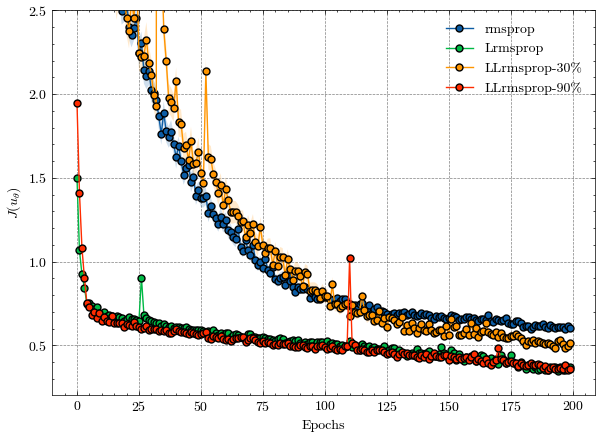

In [155]:
plot_langevin_loss(
    test_loss_rmsprop,
    test_ci_rmsprop,
    test_loss_lrmsprop,
    test_ci_lrmsprop,
    test_loss_llangevin=[test_loss_ll30_rmsprop, test_loss_ll90_rmsprop],
    test_ci_llangevin=[test_ci_ll30_rmsprop, test_ci_ll90_rmsprop],
    ll=[30, 90],
    name="rmsprop",
    ylim=(0.2, 2.5),
)